# Method 8 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

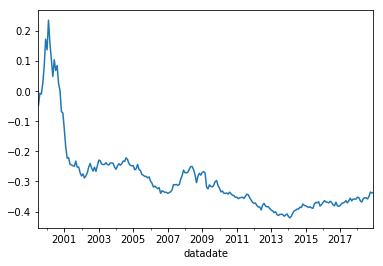

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.172673
2000-12-31   -0.209117
2001-12-31   -0.213921
2002-12-31    0.031163
2003-12-31   -0.006088
2004-12-31    0.006478
2005-12-31   -0.048931
2006-12-31   -0.071432
2007-12-31    0.111101
2008-12-31   -0.022781
2009-12-31   -0.048578
2010-12-31   -0.056109
2011-12-31   -0.026030
2012-12-31   -0.033259
2013-12-31   -0.028706
2014-12-31    0.047800
2015-12-31    0.004280
2016-12-31   -0.009475
2017-12-31    0.039190
2018-12-31    0.034992
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     12.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.33e-09
Time:                        06:51:15   Log-Likelihood:                 611.95
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.840      0.402      -0.003       0.001
mktrf          0.0015      0.033      0.045      0.964      -0.064       0.067
me            -0.0028      0.039     -0.071      0.943      -0.079       0.074
ia            -0.4165      0.059     -7.059      0.000      -0.533      -0.300
roe            0.0850      0.051      1.683      0.094      -0.015       0.184
==============================================================================
Omnibus:                       24.790   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.060
Skew:                          -0.125   Prob(JB):                     4.64e-25
Kurtosis:                       6.381   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.522
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.99e-06
Time:                        06:51:15   Log-Likelihood:                 611.95
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.726      0.468      -0.004       0.002
mktrf          0.0015      0.046      0.033      0.974      -0.088       0.091
me            -0.0028      0.122     -0.023      0.982      -0.243       0.237
ia            -0.4165      0.143     -2.919      0.004      -0.696      -0.137
roe            0.0850      0.073      1.165      0.244      -0.058       0.228
==============================================================================
Omnibus:                       24.790   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.060
Skew:                          -0.125   Prob(JB):                     4.64e-25
Kurtosis:                       6.381   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.211
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.33e-06
Time:                        06:51:15   Log-Likelihood:                 611.95
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.723      0.469      -0.004       0.002
mktrf          0.0015      0.036      0.041      0.967      -0.070       0.073
me            -0.0028      0.119     -0.023      0.981      -0.235       0.230
ia            -0.4165      0.160     -2.595      0.009      -0.731      -0.102
roe            0.0850      0.068      1.245      0.213      -0.049       0.219
==============================================================================
Omnibus:                       24.790   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.060
Skew:                          -0.125   Prob(JB):                     4.64e-25
Kurtosis:                       6.381   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     20.64
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.44e-17
Time:                        06:51:15   Log-Likelihood:                 632.18
No. Observations:                 234   AIC:                            -1252.
Df Residuals:                     228   BIC:                            -1232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.102      0.919      -0.002       0.002
mktrf         -0.0274      0.031     -0.891      0.374      -0.088       0.033
smb           -0.0953      0.041     -2.351      0.020      -0.175      -0.015
hml           -0.2951      0.048     -6.170      0.000      -0.389      -0.201
rmw           -0.1314      0.054     -2.431      0.016      -0.238      -0.025
cma            0.0291      0.069      0.423      0.673      -0.106       0.164
==============================================================================
Omnibus:                       20.694   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.905
Skew:                          -0.121   Prob(JB):                     3.29e-17
Kurtosis:                       5.780   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     28.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.25e-22
Time:                        06:51:15   Log-Likelihood:                 632.18
No. Observations:                 234   AIC:                            -1252.
Df Residuals:                     228   BIC:                            -1232.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.117      0.907      -0.002       0.002
mktrf         -0.0274      0.028     -0.973      0.330      -0.083       0.028
smb           -0.0953      0.085     -1.119      0.263      -0.262       0.072
hml           -0.2951      0.071     -4.171      0.000      -0.434      -0.156
rmw           -0.1314      0.075     -1.751      0.080      -0.279       0.016
cma            0.0291      0.104      0.279      0.780      -0.175       0.233
==============================================================================
Omnibus:                       20.694   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.905
Skew:                          -0.121   Prob(JB):                     3.29e-17
Kurtosis:                       5.780   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     40.75
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.47e-30
Time:                        06:51:15   Log-Likelihood:                 632.18
No. Observations:                 234   AIC:                            -1252.
Df Residuals:                     228   BIC:                            -1232.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.126      0.900      -0.002       0.002
mktrf         -0.0274      0.024     -1.128      0.259      -0.075       0.020
smb           -0.0953      0.074     -1.297      0.195      -0.239       0.049
hml           -0.2951      0.077     -3.809      0.000      -0.447      -0.143
rmw           -0.1314      0.082     -1.598      0.110      -0.293       0.030
cma            0.0291      0.110      0.264      0.792      -0.186       0.245
==============================================================================
Omnibus:                       20.694   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.905
Skew:                          -0.121   Prob(JB):                     3.29e-17
Kurtosis:                       5.780   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     40.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-25
Time:                        06:51:15   Log-Likelihood:                 651.02
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.755      0.081      -0.004       0.000
mktrf          0.0760      0.026      2.923      0.004       0.025       0.127
smb           -0.0764      0.032     -2.353      0.019      -0.140      -0.012
hml           -0.2981      0.032     -9.245      0.000      -0.362      -0.235
umd            0.1478      0.021      6.989      0.000       0.106       0.190
==============================================================================
Omnibus:                        5.964   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.107
Skew:                           0.019   Prob(JB):                       0.0105
Kurtosis:                       3.966   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     15.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.68e-11
Time:                        06:51:16   Log-Likelihood:                 651.02
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.644      0.100      -0.004       0.000
mktrf          0.0760      0.039      1.962      0.050    8.11e-05       0.152
smb           -0.0764      0.075     -1.020      0.308      -0.223       0.070
hml           -0.2981      0.061     -4.885      0.000      -0.418      -0.178
umd            0.1478      0.036      4.064      0.000       0.077       0.219
==============================================================================
Omnibus:                        5.964   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.107
Skew:                           0.019   Prob(JB):                       0.0105
Kurtosis:                       3.966   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     11.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.74e-09
Time:                        06:51:16   Log-Likelihood:                 651.02
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.490      0.136      -0.004       0.001
mktrf          0.0760      0.043      1.748      0.081      -0.009       0.161
smb           -0.0764      0.064     -1.184      0.236      -0.203       0.050
hml           -0.2981      0.070     -4.256      0.000      -0.435      -0.161
umd            0.1478      0.042      3.558      0.000       0.066       0.229
==============================================================================
Omnibus:                        5.964   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.107
Skew:                           0.019   Prob(JB):                       0.0105
Kurtosis:                       3.966   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     9.380
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-06
Time:                        06:51:16   Log-Likelihood:                 287.33
No. Observations:                 120   AIC:                            -564.7
Df Residuals:                     115   BIC:                            -550.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.055      0.294      -0.007       0.002
mktrf          0.0160      0.058      0.276      0.783      -0.099       0.131
me             0.0876      0.057      1.526      0.130      -0.026       0.201
ia            -0.5247      0.090     -5.837      0.000      -0.703      -0.347
roe            0.1381      0.080      1.736      0.085      -0.019       0.296
==============================================================================
Omnibus:                        6.076   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.939
Skew:                          -0.308   Prob(JB):                       0.0311
Kurtosis:                       4.005   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     5.248
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000642
Time:                        06:51:16   Log-Likelihood:                 287.33
No. Observations:                 120   AIC:                            -564.7
Df Residuals:                     115   BIC:                            -550.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.861      0.389      -0.007       0.003
mktrf          0.0160      0.078      0.204      0.838      -0.138       0.170
me             0.0876      0.128      0.686      0.493      -0.163       0.338
ia            -0.5247      0.163     -3.216      0.001      -0.844      -0.205
roe            0.1381      0.108      1.283      0.200      -0.073       0.349
==============================================================================
Omnibus:                        6.076   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.939
Skew:                          -0.308   Prob(JB):                       0.0311
Kurtosis:                       4.005   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     4.971
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000986
Time:                        06:51:16   Log-Likelihood:                 287.33
No. Observations:                 120   AIC:                            -564.7
Df Residuals:                     115   BIC:                            -550.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.823      0.410      -0.008       0.003
mktrf          0.0160      0.074      0.215      0.830      -0.130       0.162
me             0.0876      0.128      0.686      0.493      -0.163       0.338
ia            -0.5247      0.185     -2.843      0.004      -0.886      -0.163
roe            0.1381      0.104      1.330      0.184      -0.065       0.342
==============================================================================
Omnibus:                        6.076   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.939
Skew:                          -0.308   Prob(JB):                       0.0311
Kurtosis:                       4.005   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     13.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.26e-10
Time:                        06:51:16   Log-Likelihood:                 297.97
No. Observations:                 120   AIC:                            -583.9
Df Residuals:                     114   BIC:                            -567.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.262      0.794      -0.005       0.003
mktrf         -0.0330      0.056     -0.587      0.559      -0.145       0.079
smb           -0.0318      0.064     -0.499      0.619      -0.158       0.095
hml           -0.3557      0.078     -4.550      0.000      -0.511      -0.201
rmw           -0.0950      0.092     -1.030      0.305      -0.278       0.088
cma            0.0082      0.101      0.082      0.935      -0.192       0.208
==============================================================================
Omnibus:                       10.532   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.215
Skew:                          -0.468   Prob(JB):                     0.000819
Kurtosis:                       4.403   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     18.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.47e-13
Time:                        06:51:16   Log-Likelihood:                 297.97
No. Observations:                 120   AIC:                            -583.9
Df Residuals:                     114   BIC:                            -567.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.326      0.744      -0.004       0.003
mktrf         -0.0330      0.048     -0.685      0.493      -0.128       0.062
smb           -0.0318      0.105     -0.304      0.761      -0.237       0.173
hml           -0.3557      0.094     -3.802      0.000      -0.539      -0.172
rmw           -0.0950      0.086     -1.106      0.269      -0.263       0.073
cma            0.0082      0.146      0.056      0.955      -0.279       0.295
==============================================================================
Omnibus:                       10.532   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.215
Skew:                          -0.468   Prob(JB):                     0.000819
Kurtosis:                       4.403   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     27.78
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.62e-18
Time:                        06:51:16   Log-Likelihood:                 297.97
No. Observations:                 120   AIC:                            -583.9
Df Residuals:                     114   BIC:                            -567.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.342      0.733      -0.004       0.003
mktrf         -0.0330      0.048     -0.685      0.493      -0.128       0.061
smb           -0.0318      0.088     -0.363      0.717      -0.204       0.140
hml           -0.3557      0.099     -3.577      0.000      -0.551      -0.161
rmw           -0.0950      0.086     -1.108      0.268      -0.263       0.073
cma            0.0082      0.159      0.052      0.959      -0.304       0.320
==============================================================================
Omnibus:                       10.532   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.215
Skew:                          -0.468   Prob(JB):                     0.000819
Kurtosis:                       4.403   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     37.36
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.38e-20
Time:                        06:51:16   Log-Likelihood:                 320.35
No. Observations:                 120   AIC:                            -630.7
Df Residuals:                     115   BIC:                            -616.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -1.149      0.253      -0.005       0.001
mktrf          0.1346      0.039      3.461      0.001       0.058       0.212
smb           -0.0713      0.044     -1.611      0.110      -0.159       0.016
hml           -0.3561      0.044     -8.030      0.000      -0.444      -0.268
umd            0.1998      0.027      7.307      0.000       0.146       0.254
==============================================================================
Omnibus:                        2.495   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.380
Skew:                          -0.272   Prob(JB):                        0.304
Kurtosis:                       2.576   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     13.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.34e-09
Time:                        06:51:16   Log-Likelihood:                 320.35
No. Observations:                 120   AIC:                            -630.7
Df Residuals:                     115   BIC:                            -616.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.359      0.174      -0.005       0.001
mktrf          0.1346      0.046      2.901      0.004       0.044       0.225
smb           -0.0713      0.073     -0.972      0.331      -0.215       0.072
hml           -0.3561      0.056     -6.309      0.000      -0.467      -0.245
umd            0.1998      0.036      5.570      0.000       0.129       0.270
==============================================================================
Omnibus:                        2.495   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.380
Skew:                          -0.272   Prob(JB):                        0.304
Kurtosis:                       2.576   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     9.107
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.99e-06
Time:                        06:51:16   Log-Likelihood:                 320.35
No. Observations:                 120   AIC:                            -630.7
Df Residuals:                     115   BIC:                            -616.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -1.214      0.225      -0.005       0.001
mktrf          0.1346      0.048      2.804      0.005       0.041       0.229
smb           -0.0713      0.063     -1.131      0.258      -0.195       0.052
hml           -0.3561      0.060     -5.903      0.000      -0.474      -0.238
umd            0.1998      0.041      4.815      0.000       0.118       0.281
==============================================================================
Omnibus:                        2.495   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.380
Skew:                          -0.272   Prob(JB):                        0.304
Kurtosis:                       2.576   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     21.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.40e-13
Time:                        06:51:16   Log-Likelihood:                 394.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.690      0.492      -0.002       0.001
mktrf          0.0254      0.023      1.114      0.268      -0.020       0.070
me            -0.2457      0.035     -6.990      0.000      -0.315      -0.176
ia            -0.0725      0.049     -1.488      0.140      -0.169       0.024
roe            0.1076      0.043      2.511      0.014       0.023       0.192
==============================================================================
Omnibus:                       10.816   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.918
Skew:                           0.603   Prob(JB):                      0.00258
Kurtosis:                       4.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     33.04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.94e-18
Time:                        06:51:16   Log-Likelihood:                 394.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.763      0.446      -0.002       0.001
mktrf          0.0254      0.016      1.625      0.104      -0.005       0.056
me            -0.2457      0.028     -8.879      0.000      -0.300      -0.191
ia            -0.0725      0.056     -1.298      0.194      -0.182       0.037
roe            0.1076      0.029      3.743      0.000       0.051       0.164
==============================================================================
Omnibus:                       10.816   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.918
Skew:                           0.603   Prob(JB):                      0.00258
Kurtosis:                       4.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     43.78
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.32e-22
Time:                        06:51:16   Log-Likelihood:                 394.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     109   BIC:                            -766.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.737      0.461      -0.002       0.001
mktrf          0.0254      0.013      1.960      0.050   -4.83e-06       0.051
me            -0.2457      0.023    -10.845      0.000      -0.290      -0.201
ia            -0.0725      0.056     -1.303      0.192      -0.182       0.037
roe            0.1076      0.028      3.907      0.000       0.054       0.162
==============================================================================
Omnibus:                       10.816   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.918
Skew:                           0.603   Prob(JB):                      0.00258
Kurtosis:                       4.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     17.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.79e-13
Time:                        06:51:16   Log-Likelihood:                 395.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     108   BIC:                            -763.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.623      0.535      -0.002       0.001
mktrf          0.0107      0.022      0.495      0.622      -0.032       0.054
smb           -0.2296      0.035     -6.542      0.000      -0.299      -0.160
hml           -0.0381      0.045     -0.850      0.397      -0.127       0.051
rmw            0.1313      0.055      2.396      0.018       0.023       0.240
cma           -0.0206      0.070     -0.297      0.767      -0.159       0.117
==============================================================================
Omnibus:                        8.184   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.163
Skew:                           0.526   Prob(JB):                       0.0169
Kurtosis:                       3.781   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     39.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.95e-23
Time:                        06:51:16   Log-Likelihood:                 395.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     108   BIC:                            -763.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.652      0.515      -0.002       0.001
mktrf          0.0107      0.014      0.756      0.450      -0.017       0.038
smb           -0.2296      0.025     -9.111      0.000      -0.279      -0.180
hml           -0.0381      0.040     -0.941      0.347      -0.117       0.041
rmw            0.1313      0.038      3.501      0.000       0.058       0.205
cma           -0.0206      0.081     -0.253      0.800      -0.180       0.139
==============================================================================
Omnibus:                        8.184   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.163
Skew:                           0.526   Prob(JB):                       0.0169
Kurtosis:                       3.781   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     50.62
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.08e-27
Time:                        06:51:16   Log-Likelihood:                 395.95
No. Observations:                 114   AIC:                            -779.9
Df Residuals:                     108   BIC:                            -763.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.601      0.548      -0.002       0.001
mktrf          0.0107      0.012      0.899      0.368      -0.013       0.034
smb           -0.2296      0.021    -10.763      0.000      -0.271      -0.188
hml           -0.0381      0.037     -1.028      0.304      -0.111       0.034
rmw            0.1313      0.035      3.792      0.000       0.063       0.199
cma           -0.0206      0.082     -0.252      0.801      -0.181       0.140
==============================================================================
Omnibus:                        8.184   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.163
Skew:                           0.526   Prob(JB):                       0.0169
Kurtosis:                       3.781   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     19.97
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.35e-12
Time:                        06:51:16   Log-Likelihood:                 393.16
No. Observations:                 114   AIC:                            -776.3
Df Residuals:                     109   BIC:                            -762.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.254      0.800      -0.002       0.001
mktrf         -0.0001      0.022     -0.007      0.995      -0.044       0.043
smb           -0.2588      0.034     -7.574      0.000      -0.327      -0.191
hml           -0.0895      0.035     -2.545      0.012      -0.159      -0.020
umd           -0.0068      0.027     -0.255      0.799      -0.059       0.046
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.078
Skew:                           0.530   Prob(JB):                       0.0479
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     44.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.71e-22
Time:                        06:51:16   Log-Likelihood:                 393.16
No. Observations:                 114   AIC:                            -776.3
Df Residuals:                     109   BIC:                            -762.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.268      0.789      -0.002       0.001
mktrf         -0.0001      0.017     -0.009      0.993      -0.033       0.032
smb           -0.2588      0.030     -8.697      0.000      -0.317      -0.200
hml           -0.0895      0.027     -3.353      0.001      -0.142      -0.037
umd           -0.0068      0.022     -0.309      0.757      -0.050       0.036
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.078
Skew:                           0.530   Prob(JB):                       0.0479
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     53.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.97e-25
Time:                        06:51:16   Log-Likelihood:                 393.16
No. Observations:                 114   AIC:                            -776.3
Df Residuals:                     109   BIC:                            -762.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.246      0.806      -0.002       0.001
mktrf         -0.0001      0.015     -0.010      0.992      -0.029       0.029
smb           -0.2588      0.025    -10.248      0.000      -0.308      -0.209
hml           -0.0895      0.024     -3.714      0.000      -0.137      -0.042
umd           -0.0068      0.017     -0.402      0.688      -0.040       0.026
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.078
Skew:                           0.530   Prob(JB):                       0.0479
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""